<a href="https://colab.research.google.com/github/brentianpalmer/FinMarketsFinal/blob/main/Results_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pprint
from statsmodels.iolib.table import SimpleTable
import pandas as pd
import collections

inputs = {
          'delta': 0.25, 
          'T': 3, 
          'q': 0, 
          'k_stock_lognormal': 1, 
          'k_libor_lognormal': 1,
          'Nsim': 100000, 
          'L0': 0.0034, 
          'sigma_l': 0.08, 
          'sigma_p': 0.05, 
          'rho_sl': 0.65, 
          'xp': [1.0/12, 2.0/12, 3.0/12, 0.5, 1, 2, 3, 5, 7, 10, 20, 30],
          'yp': [0.02,	0.01,	0.02,	0.04,	0.05,	0.16,
                 0.32,	0.80,	1.27,	1.63,	2.20,	2.32], 
          }

def lognormalPricer(inputs=inputs):
    outputs = {}
    T = inputs.get('T')
    delta = inputs.get('delta')
    k_stock_lognormal = inputs.get('k_stock_lognormal')
    S0 = 271.27211906501435
    # Japan 3 year government bond yield (from market data (3yr yield)
    r_f = -0.00138
    # -------- Correlations --------- #
    # Correlation stock and exchange rate #
    rho_sx = -0.3049678  # correl (NI225 in USD, USD/JPY (DOM exchange rate))
    
    # Correl (NI225 in USD, bond maturing in 3 years) *** THIS IS MADE UP ***
    rho_sl = inputs.get('rho_sl')
    rho_sp = -rho_sl
    # -------- Volatilities --------- #
    sigma_s = 0.199468950979314  # Volatility of NI225 in USD
    sigma_x = 0.0519824811701589  # Volatility of USD/JPY (DOM exchange rate).

    quanto_adj = r_f - inputs.get('q') - rho_sx * sigma_s * sigma_x
    girsanov_chg_measure_QT = sigma_s * inputs.get('sigma_p') * rho_sp

    Nsim = inputs.get('Nsim')
    # Process for Generating Correlated Random Samples from Normal distribution from Hull Chapter 21
    # np.random.seed(456)
    # random sample from standard normal dist
    rand1 = np.random.normal(0, 1, Nsim)
    # another random sample from different standard normal dist
    rand2 = np.random.normal(0, 1, Nsim)
    eps = rand1  # eps for stock lognormal simulation
    # eps for libor lognormal simulation
    eps_tilda = (rho_sl*rand1)+rand2*np.sqrt(1-rho_sl**2)
    outputs['eps'] = eps
    outputs['eps_tilda'] = eps_tilda

    # As a result, we now can simulate ST with a one-step monte carlo as follows:
    ST = S0 * np.exp((quanto_adj + girsanov_chg_measure_QT-0.5 *
                      sigma_s*sigma_s)*T + sigma_s*np.sqrt(T)*eps) # The MC scheme with vectorized NumPy code handling all paths at once.
    ST_avg = np.average(ST)

    # Equity Ratio at time T:
    ST_over_S0 = ST/S0
    ST_over_S0_avg = np.average(ST_over_S0)

    # Equity Ratio vs. strike price k
    ST_over_S0_k = ST_over_S0-k_stock_lognormal
    ST_over_S0_avg_k = ST_over_S0_avg-k_stock_lognormal

    outputs['ST'] = ST
    outputs['ST_avg'] = ST_avg
    outputs['ST_over_S0'] = ST_over_S0
    outputs['ST_over_S0_avg'] = ST_over_S0_avg
    outputs['ST_over_S0_k'] = ST_over_S0_k
    outputs['ST_over_S0_avg_k'] = ST_over_S0_avg_k

    xp = inputs.get('xp')
    yp = inputs.get('yp')
    L0 = inputs.get('L0')

    x_hat = np.arange(0, 30.25, 0.25)
    y_interp = np.interp(x_hat, xp, yp)
    
    # Y(0,T) is the yield-to-maturity on a zero coupon bond maturing at time T, 
    # which we use to calculate p(0,T).
    y_0T = np.interp(T, xp, yp)

    # Y(0,T-delta) is the yield-to-maturity on a zero coupon bond maturing 
    # at time T-delta. This is used to calculated p(0,T-delta).
    y_0Td = np.interp(T-delta, xp, yp)
    
    # p(0,T) is the value at time 0 of receiving a dollar at time T
    # This is also called the discount factor
    p_0T = np.exp(-y_0T/100*T)

    # p(0,T-delta)is the value at time 0 of receiving a dollar at time T-delta
    p_0Td = np.exp(-y_0Td/100*(T-delta)) 

    # sigma_l is the vol of libor
    sigma_l = inputs.get('sigma_l')

    # We then simulate L(T-delta,T-delta,T) via a Monte Carlo simulation 
    # starting at L0
    L_TdTdT = L0 * np.exp(sigma_l * np.sqrt(T - delta) *
                         eps_tilda - 0.5*sigma_l*sigma_l*(T-delta))
    
    # Average L(T-delta,T-delta,T) # Numerator of payoff
    L_TdTdT_avg = np.average(L_TdTdT) 


    # We then derive from market data for L(0,T-delta,T) 
    # L(0,T-delta,T) is L_0TdT #Denominator of payoff
    L_0TdT = -(p_0T - p_0Td)/(delta*p_0T)

    # Average of L(0,T-delta,T) is L_0TdT #Denominator of payoff L(0,T-delta,T)
    L_0TdT_avg = np.average(L_0TdT)

    # Libor ratio of payoff L(T-delta,T-delta,T) over L(0,T-delta,T)
    L_TdTdT_over_L_0TdT = L_TdTdT/L_0TdT
    L_TdTdT_over_L_0TdT_avg = np.average(L_TdTdT_over_L_0TdT)

    # Get libor strike K from inputs
    k_libor_lognormal = inputs.get('k_libor_lognormal')
    
    # Calculate payoff for equity and libor ratios relative to strikes, k, and multiply
    pi = np.maximum(0, np.multiply(
        (ST_over_S0 - k_stock_lognormal), (k_libor_lognormal-L_TdTdT_over_L_0TdT)))
    pi_avg = np.average(pi)

    # Discount pi back to today using p(0,T)
    price = p_0T * pi_avg

    outputs['x_hat'] = x_hat
    outputs['y_interp'] = y_interp
    outputs['y_0T'] = y_0T
    outputs['y_0Td'] = y_0Td
    outputs['p_0T'] = p_0T
    outputs['p_0Td'] = p_0Td
    outputs['L_0TdT'] = L_0TdT
    outputs['L_0TdT_avg'] = L_0TdT_avg
    outputs['L_TdTdT'] = L_TdTdT
    outputs['L_TdTdT_avg'] = L_TdTdT_avg
    outputs['L_TdTdT_over_L_0TdT'] = L_TdTdT_over_L_0TdT
    outputs['L_TdTdT_over_L_0TdT_avg'] = L_TdTdT_over_L_0TdT_avg
    outputs['pi'] = pi
    outputs['pi_avg'] = pi_avg
    outputs['price'] = price

    return outputs

outputs = lognormalPricer(inputs)

print("Complete")



Complete


In [ ]:
#@title
def stock_graph():
    S0 = inputs.get('S0')
    ST = outputs.get('ST')
    ST_avg = outputs.get('ST_avg')
    x = []
    y = []
    for i in ST:
        y.append(i)
        y.append(S0)
        x.append(1)
        x.append(0)
    plt.figure(figsize=(10, 6))
    plt.title("One-Step Monte Carlo Simulation for Stock")
    plt.plot(x, y, label='paths')
    plt.axhline(ST_avg, color='r', label='mean value of ST')
    plt.legend(loc='upper left')
    plt.xticks()
    plt.xticks(np.arange(0, 1.1, step=1))
    plt.xticks([0, 1], ['0', 'T'])
    print("ST mean: ", ST.mean())
    plt.show()

def ST_outcomes():
    ST = outputs.get('ST')
    ST_avg = outputs.get('ST_avg')
    plt.figure(figsize=(10, 6))
    plt.hist(ST, bins=35, label='ST')
    plt.axvline(ST_avg, color='r', label='ST_avg')
    plt.title("ST Outcomes")
    plt.legend(loc=0)
    print("ST_avg: ", ST_avg)
    plt.legend(loc=0)
    plt.show()

def ST_over_SO_outcomes():
    ST_over_S0_avg = outputs.get('ST_over_S0_avg')
    ST_over_S0 = outputs.get('ST_over_S0')
    plt.figure(figsize=(10, 6))
    plt.hist(ST_over_S0, bins=35, label='Stock Payoff (ST/SO)')
    plt.title("Stock Payoff (ST/S0)")
    plt.axvline(ST_over_S0_avg, color='r', label='Stock_payoff_avg')
    plt.legend(loc=0)
    print("ST_over_S0_avg (ST/S0): ", ST_over_S0_avg)
    plt.legend(loc=0)
    # print("Stock Portion of Payoff ((ST/S0)- k, where k=1): ", ST_over_S0_avg-1)
    plt.show()

def yield_curve_display():
    xp = inputs.get('xp')
    yp = inputs.get('yp')
    x_hat = outputs.get('x_hat')
    y_interp = outputs.get('y_interp')
    plt.figure(figsize=(10, 6))
    plt.plot(xp, yp, 'o', label='US Treasury Yield Curve Constant Maturity Rates')
    plt.title("Interpolated US Treasury Yield Curve Rates on May 10, 2021")
    plt.plot(x_hat, y_interp, 'o', alpha=0.5, label='Interpolated Treasury Yield Curve')
    plt.legend(loc=0)
    plt.xlabel("Maturity")
    plt.ylabel("Yield")
    plt.show()

def TS_info():
    y_0T = outputs.get('y_0T')
    print ("y_0T:", y_0T)
    y_0Td = outputs.get('y_0Td') 
    print ("y_0Td:", y_0Td)
    p_0T = outputs.get('p_0T') 
    print("p_0T: ",p_0T)    
    L0 = inputs.get('L0')
    print("L0: ",L0)

def L_TdTdT_Outcomes():
    L_TdTdT = outputs.get('L_TdTdT')
    L_TdTdT_avg = outputs.get('L_TdTdT_avg')
    plt.figure(figsize=(10, 6))
    plt.hist(L_TdTdT, label='L_TdTdT')
    plt.axvline(L_TdTdT_avg, color='r', label='L_TdTdT_avg')
    plt.title("L_TdTdT_Outcomes")
    print("L_TdTdT_avg: ", L_TdTdT_avg)
    plt.legend(loc=0)
    plt.show()

def L_TdTdT_over_L_0TdT_Outcomes():
    L_TdTdT_over_L_0TdT = outputs.get('L_TdTdT_over_L_0TdT')
    L_TdTdT_over_L_0TdT_avg = outputs.get('L_TdTdT_over_L_0TdT_avg')
    print("L_TdTdT_over_L_0TdT_avg: ", L_TdTdT_over_L_0TdT_avg)
    plt.figure(figsize=(10, 6))
    plt.hist(L_TdTdT_over_L_0TdT, label='L')
    plt.axvline(L_TdTdT_over_L_0TdT_avg, color='r', label='L_TdTdT_over_L_0TdT_avg')
    plt.title("L_TdTdT_over_L_0TdT_Outcomes")
    plt.legend(loc=0)
    plt.show()

def pi_outcomes():
    plt.figure(figsize=(10, 6))
    pi = outputs.get('pi')
    pi_avg = outputs.get('pi_avg')
    plt.hist(pi)
    plt.title("Method 2: payoff at T")
    print("Average payoff is: ", pi_avg)
    plt.show()

def display_price():
    price = outputs.get('price')
    print(price)


In [ ]:
#@title
print("Inputs:")

for k,v in inputs.items():
  print(k,v)

Inputs:
delta 0.25
T 3
q 0
k_stock_lognormal 1
k_libor_lognormal 1
Nsim 100000
L0 0.0034
sigma_l 0.08
sigma_p 0.05
rho_sl 0.65
xp [0.08333333333333333, 0.16666666666666666, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yp [0.02, 0.01, 0.02, 0.04, 0.05, 0.16, 0.32, 0.8, 1.27, 1.63, 2.2, 2.32]


In [ ]:
#@title
display_outputs = {key: outputs[key] for key in outputs.keys()
                               & { 'ST_avg', 
'ST_over_S0_avg', 
'ST_over_S0_avg_k',
'y_0T', 'y_0Td', 'p_0T', 'p_0Td' ,'L_0TdT_avg', 'L_TdTdT_avg', 'L_TdTdT_over_L_0TdT_avg', 'pi_avg', 'price'}}

display_outputs_ordered = collections.OrderedDict()

display_outputs_ordered['ST_over_S0_avg'] = display_outputs['ST_over_S0_avg']
display_outputs_ordered['ST_over_S0_avg_k'] = display_outputs['ST_over_S0_avg_k']
display_outputs_ordered['y_0T'] = display_outputs['y_0Td']
display_outputs_ordered['p_0T'] = display_outputs['p_0T']
display_outputs_ordered['p_0Td'] = display_outputs['p_0Td']
display_outputs_ordered['L_0TdT_avg'] = display_outputs['L_0TdT_avg']
display_outputs_ordered['L_TdTdT_avg'] = display_outputs['L_TdTdT_avg']
display_outputs_ordered['L_TdTdT_over_L_0TdT_avg'] = display_outputs['L_TdTdT_over_L_0TdT_avg']
display_outputs_ordered['pi_avg'] = display_outputs['pi_avg']
display_outputs_ordered['price'] = display_outputs['price']

print("Simulation Results:")
for k, v in display_outputs_ordered.items():
    print (k, v)


Simulation Results:
ST_over_S0_avg 0.9860195136559762
ST_over_S0_avg_k -0.013980486344023824
y_0T 0.28
p_0T 0.990445932897216
p_0Td 0.9923295690574124
L_0TdT_avg 0.007607224574839476
L_TdTdT_avg 0.003399659844192899
L_TdTdT_over_L_0TdT_avg 0.4468988407989306
pi_avg 0.06391136659616857
price 0.06330075311107815


In [ ]:
#@title
df_results = pd.DataFrame.from_dict([display_outputs_ordered])
df_results
df_results.to_excel("df_results.xlsx", sheet_name='Sheet_name_1')

ST_avg:  267.47960290891166


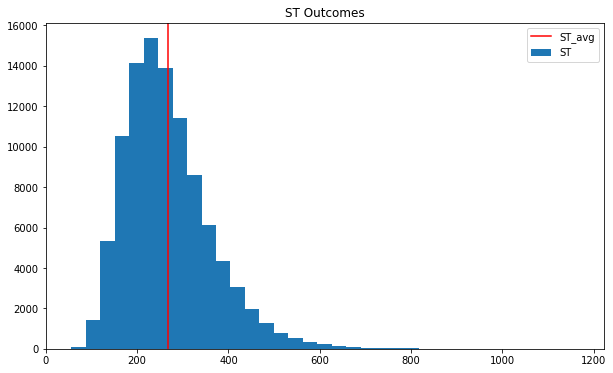

ST_over_S0_avg (ST/S0):  0.9860195136559762


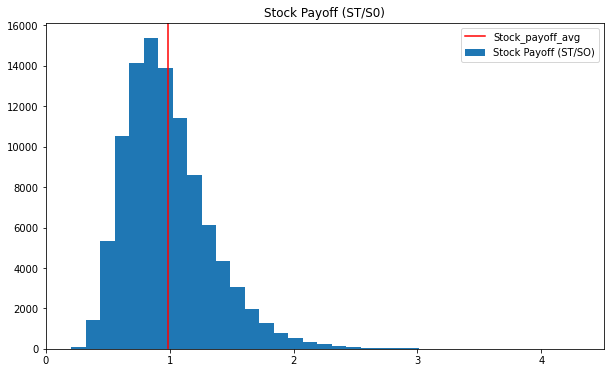

In [ ]:
#@title

# stock_graph()

ST_outcomes()
ST_over_SO_outcomes()


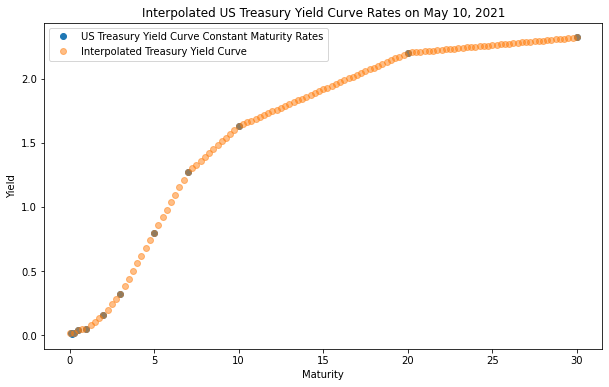

y_0T: 0.32
y_0Td: 0.28
p_0T:  0.990445932897216
L0:  0.0034


In [ ]:
yield_curve_display()
TS_info()

L_TdTdT_avg:  0.003399659844192899


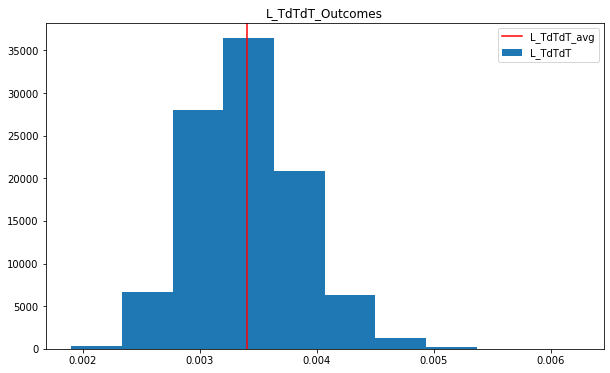

L_TdTdT_over_L_0TdT_avg:  0.4468988407989306


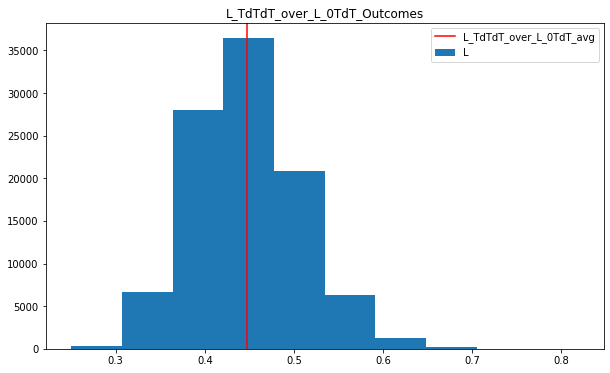

Average payoff is:  0.06391136659616857


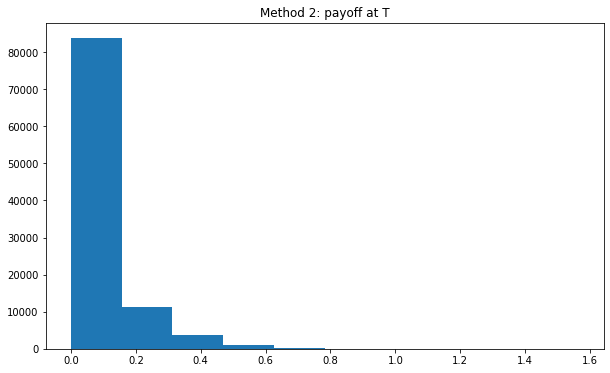

0.06330075311107815


In [ ]:
L_TdTdT_Outcomes()
L_TdTdT_over_L_0TdT_Outcomes()
pi_outcomes()
display_price()